# Importando bibliotecas e carregando dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

df = pd.read_csv('star_classification.csv')

df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


# 1 - Preparando dataset para a rede neural

In [ ]:
df.drop(['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'plate', 'MJD', 'fiber_ID'], axis=1, inplace=True)

In [ ]:
df['class'] = df['class'].map({'GALAXY':0, 'STAR':1, 'QSO':2})

In [ ]:
df.head()

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0,0.116123


# 2 - Criando a Rede Neural

## Criando a classe da rede neural

In [ ]:
class Model(nn.Module):
  def __init__(self, in_features=8, h1=32, h2=32, h3=32, out_features=3):
      super(Model, self).__init__()
      self.fc1 = nn.Linear(in_features, h1)
      self.fc2 = nn.Linear(h1, h2)
      self.fc3 = nn.Linear(h2, h3)
      self.out = nn.Linear(h3, out_features)

  def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.out(x)
      return x

In [ ]:
# Defining a manual seed for randomization
torch.manual_seed(42)

# Instantiating the model
model = Model()

In [ ]:
X = df.drop('class', axis=1).values
y = df['class'].values

In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Convert X features to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Convert y labels to tensors long
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Choose Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# 3 - Treinando a Rede Neural

In [ ]:
# Train our model!
# Epoch (one run through all the training data in out network)
epochs = 4800
losses = []

for i in range(epochs):
  # Go forward and get a prediction
  y_pred = model(X_train) # Use the standard functional call for the forward pass

  # Measure the loss (gonna be high at first)
  loss = criterion(y_pred, y_train) # predicted values vs y_train

  # Keep track of losses
  losses.append(loss.detach().numpy())

  # Print every 10 epochs
  if i % 300 == 0:
    print(f'Epoch: {i} Loss: {loss}')

  # Do some backpropagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0 Loss: 5.006803035736084
Epoch: 300 Loss: 0.9036378860473633
Epoch: 600 Loss: 0.5328165292739868
Epoch: 900 Loss: 0.3669126033782959
Epoch: 1200 Loss: 0.3138654828071594
Epoch: 1500 Loss: 0.27550607919692993
Epoch: 1800 Loss: 0.24825607240200043
Epoch: 2100 Loss: 0.22874049842357635
Epoch: 2400 Loss: 0.21390248835086823
Epoch: 2700 Loss: 0.2027382254600525
Epoch: 3000 Loss: 0.19352105259895325
Epoch: 3300 Loss: 0.18580542504787445
Epoch: 3600 Loss: 0.1808161586523056
Epoch: 3900 Loss: 0.17308194935321808
Epoch: 4200 Loss: 0.1681067794561386
Epoch: 4500 Loss: 0.1631470024585724


## Gráfico Epoch X Loss

Text(0.5, 0, 'Epoch')

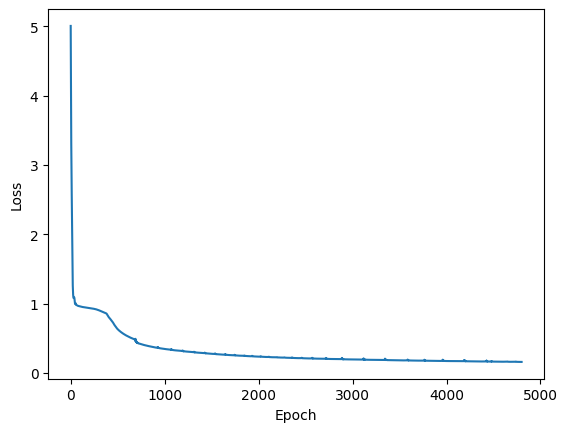

In [ ]:
# Making a graph
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

## Avaliando o modelo no conjunto de teste

In [ ]:
# Evaluate Model on Test Data Set (validate model on test set)
with torch.no_grad():
  y_eval = model(X_test)
  loss = criterion(y_eval, y_test)

In [ ]:
correct = 0
with torch.no_grad():
  for i, data in enumerate(X_test):
    y_val = model(data)
    if y_val.argmax().item() == y_test[i]:
      correct += 1

print(f'{correct} out of {len(y_test)} = {100*correct/len(y_test)}% correct')

19089 out of 20000 = 95.445% correct


In [ ]:
df

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0,0.116123
...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,0,0.000000
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,0,0.404895
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,0,0.143366
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,0,0.455040
